# 8760 Notebook

### Imports

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cftime
import xarray as xr
import hvplot.xarray
import holoviews as hv
import panel as pn
from typing import List, Union, Tuple
from climakitae.explore.vulnerability import cava_data
from climakitae.util.utils import add_dummy_time_to_wl
from climakitae.explore.threshold_tools import (
    get_block_maxima,
    get_return_value,
    get_ks_stat,
    _get_fitted_distr,
    _calculate_return,
    _conf_int,
    _get_distr_func,
)
random.seed(42)

### Global Variables

In [2]:
# Putting locations into a DataFrame
locations = {
    "goleta": (34.486652, -119.894310),
    "iv": (34.427741, -119.855950),
    "sb_mountains": (34.518453, -119.799645),
    "valencia": (34.432468, -118.571098),
    "castaic": (34.492141, -118.605053),
    "lebec": (34.680102, -118.789246),
}

df = pd.DataFrame.from_dict(locations, orient='index', columns=['lat', 'lon']).reset_index()
df.rename(columns={'index': 'location'}, inplace=True)

In [3]:
# Santa Barbara area
sb = df.iloc[:3][['lat', 'lon']]
sb_locs = ['goleta', 'iv', 'sb_mountains']

# Santa Clarita area
sc = df.iloc[3:6][['lat', 'lon']]
sc_locs = ['valencia', 'castaic', 'lebec']

In [4]:
# Set params for 1-in-X calculations
one_in_x = np.array([10, 100])
event_duration = (1, 'day')
distr = 'gev'

### Plotting helper functions

In [5]:
def plot_retvals(calc_data: xr.Dataset, time_axis: bool = False) -> None:
    """
    Plot return values (or Julian day equivalents) from a calculation dataset.

    Args:
        calc_data (xr.Dataset): 
            An xarray Dataset containing dimensions including 'one_in_x', 
            'simulation', and 'location', with return value data.
        time_axis (bool, optional): 
            If True, divides the data by 24 to plot in Julian days.
            If False, plots the raw return values. Defaults to False.

    Returns:
        None
    """
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    
    for j, xval in enumerate(calc_data.one_in_x.values):
        idx = np.where(calc_data['one_in_x'].values == xval)[0].item()
        data = calc_data.isel(one_in_x=idx)
        
        if time_axis:
            data = data / 24
        
        # Let xarray create the legend only on the first plot
        data.plot.line(
            ax=ax[j], hue='location', add_legend=(j == 0)
        )
        
        labels = [sim.item().split('_')[1] for sim in calc_data.simulation.values]
        ax[j].set_xticks(range(len(labels)))
        ax[j].set_xticklabels(labels, rotation=45, ha='right')
    
        ax[j].set_title(f"1-in-{xval} by GCM")
        ax[j].set_xlabel('GCM')
        
        if j == 0:
            if time_axis:
                ax[j].set_ylabel('Median Julian Day')
            else:
                ax[j].set_ylabel('Max Return Value')
        else:
            ax[j].set_ylabel('')
            
    plt.tight_layout()
    plt.show()

In [6]:
def plot_med_val_by_locs(calc_data: xr.Dataset, time_axis: bool = False) -> None:
    """
    Plot median return values by location for each return period.

    Args:
        calc_data (xr.Dataset):
            An xarray Dataset containing dimensions 'simulation', 'one_in_x', and 'location'.
            Expected to have return value data across simulations and locations.
        time_axis (bool, optional):
            If True, converts values from hours to Julian days by dividing by 24.
            If False, plots the raw return values. Defaults to False.

    Returns:
        None; just generates the figure
    """
    # Median return values
    med = calc_data.median(dim='simulation')
    
    one_in_x_vals = med['one_in_x'].values
    locations = med['location'].values
    
    n_groups = len(one_in_x_vals)
    n_locs = len(locations)
    
    bar_width = 0.1        # smaller width = visible space between bars
    group_width = n_locs * bar_width
    x = np.linspace(0, 0.5, n_groups)    # base x for each group
    
    fig, ax = plt.subplots(figsize=(6, 5))
    
    for i, loc in enumerate(locations):
        y = med.sel(location=loc).values
        if time_axis:
            y = y / 24
        offset = (i - (n_locs - 1) / 2) * bar_width  # center the group
        bar_positions = x + offset
        bars = ax.bar(bar_positions, y, width=bar_width - 0.01, label=str(loc))
    
        # Add text labels above each bar
        for xpos, height in zip(bar_positions, y):
            ax.text(xpos, height + 0.5, f'{height:.2f}', ha='center', va='bottom', fontsize=8)
    
    ymax = med.max().item()
    if time_axis:
        ymax = ymax / 24
    
    ax.set_ylim(top=ymax * 1.1)
    
    # Center group labels
    ax.set_xticks(x)
    ax.set_xticklabels([f"1-in-{v}" for v in one_in_x_vals])
    
    # Labels and formatting
    ax.set_xlabel('Return Period')
    if time_axis:
        ax.set_ylabel('Median Julian Day')
    else:
        ax.set_ylabel('1-in-X Max Value')
    ax.set_title('Median Return Values by Location')
    ax.legend(title='Location', loc='upper right', bbox_to_anchor=(1.35, 1))
    plt.show()

In [7]:
def plot_modified8760s(
    modified8760: xr.DataArray,
    figsize: tuple = (15, 8)
) -> None:
    """
    Plot modified 8760-hour data with two rows (one_in_x) and three columns (locations).

    Args:
        modified8760 (xr.DataArray):
            DataArray with dimensions ('hour_of_year', 'location', 'one_in_x').
        figsize (tuple, optional):
            Size of the entire figure. Defaults to (15, 8).

    Returns:
        None
    """
    plot = modified8760.plot.line(
        x='hour_of_year',
        row='one_in_x',
        col='location',
        sharey=False,
        aspect=2,
        figsize=figsize
    )

    # Adjust titles for each column
    for ax, loc in zip(plot.axs[0], modified8760.location.values):
        ax.set_title(loc, fontsize=16)

    # Adjust y-axis labels
    for row_i, one_in_x_val in enumerate(modified8760.one_in_x.values):
        for col_i, ax in enumerate(plot.axs[row_i]):
            if col_i == 0:
                # First column only: bold "1-in-X" label horizontally
                ax.set_ylabel(
                    rf"$\bf{{1\text{{-}}in\text{{-}}{int(one_in_x_val)}}}$" + "\n" + "degF",
                    fontsize=16,
                    rotation=0,
                    labelpad=40,
                    ha='center',
                    va='center',
                )
    
    plt.tight_layout()
    plt.show()

### Cleaning Helpers, `one_in_x` calculations, and Finding the Median Hours for 8760s

In [8]:
def clean_raw_data(raw_data: List[xr.Dataset], loc_names: List[str]) -> xr.Dataset:
    """
    Combines raw datasets together by new `location` dimension, creates a dummy time axis, and creates an hour-of-year coordinate.

    Args:
        raw_data (List[xr.Dataset]):
            A list of xarray Datasets, one for each location.
        loc_names (List[str]):
            A list of location names corresponding to the datasets.

    Returns:
        xr.Dataset:
            A single combined xarray Dataset with cleaned time and added 'hour_of_year' coordinate.
    """
    # raw_data, calc_data = cava_data_retval['raw_data'], cava_data_retval['calc_data']
    total_raw = xr.concat(raw_data, dim='location').assign_coords(location=loc_names)
    # total_calc = xr.concat(calc_data, dim='location').assign_coords(location=loc_names)
    total_raw = add_dummy_time_to_wl(total_raw)

    # Making new time axis without leap days
    total_raw['time'] = xr.cftime_range(
        start=f'{total_raw.time.dt.year[0].item()}-01-01', 
        periods=total_raw.sizes['time'], 
        freq='H', 
        calendar='noleap'
    )

    # Make new dimension for `hour_of_year`
    hour_of_year = (total_raw['time'].dt.dayofyear - 1) * 24 + total_raw['time'].dt.hour
    total_raw = total_raw.assign_coords(hour_of_year=hour_of_year)
    
    return total_raw

In [9]:
def get_one_in_x(
    da: xr.DataArray,
    one_in_x: Union[int, float],
    event_duration: Tuple[int, str],
    distr: str
) -> xr.DataArray:
    """
    Calculate the 1-in-X year return value for a given dataset and event duration.

    Args:
        da (xr.DataArray):
            Input xarray DataArray containing the data to analyze.
        one_in_x (Union[int, float]):
            Return period (e.g., 10 for 1-in-10 years) to calculate.
        event_duration (Tuple[int, str]):
            Duration grouping for block maxima, given as (amount, unit) 
            e.g., (1, 'hour'), (3, 'day').
        distr (str):
            Name of the statistical distribution to fit (e.g., 'gev', 'gumbel').

    Returns:
        xr.DataArray:
            DataArray of the 1-in-X return values calculated across simulations or points.
    """
    ams = get_block_maxima(
        da.squeeze(),
        extremes_type='max',
        groupby=event_duration,
        check_ess=False,
    ).squeeze()
    
    return get_return_value(
        ams,
        return_period=one_in_x,
        multiple_points=False,
        distr=distr,
    )

In [10]:
def find_med_hrs(
    raw_data: xr.Dataset,
    all_one_in_x: xr.Dataset
) -> xr.DataArray:
    """
    Finds the median hour-of-year of times with temperatures that fall between confidence interval bounds.

    Args:
        raw_data (xr.Dataset):
            Raw climate or observational data with dimensions including 'time', 'location', and 'simulation'.
        all_one_in_x (xr.Dataset):
            Dataset containing confidence interval bounds ('conf_int_lower_limit' and 'conf_int_upper_limit')
            for each 'one_in_x' return period.

    Returns:
        xr.DataArray:
            Median hour-of-year for each location, simulation, and return period ('one_in_x').
    """
    subset = raw_data.resample(time='1D').max()

    tmp = subset.where(
        (subset > all_one_in_x['conf_int_lower_limit']) &
        (subset < all_one_in_x['conf_int_upper_limit'])
    )
    
    # Removing leap days
    tmp['time'] = xr.cftime_range(
        start=f'{tmp.time.dt.year[0].item()}-01-01', 
        periods=tmp.sizes['time'], 
        freq='D', 
        calendar='noleap'
    )
    
    hour_of_year = (tmp['time'].dt.dayofyear - 1) * 24 + tmp['time'].dt.hour
    tmp = tmp.assign_coords(hour_of_year=hour_of_year)

    med_hrs = tmp.groupby(["location", "simulation", "one_in_x"]).apply(
        lambda x: x.dropna(dim="time").hour_of_year.median()
    )
    
    med_hrs = med_hrs.assign_coords(simulation=med_hrs['simulation'].astype(str))
    med_hrs = med_hrs.assign_coords(location=med_hrs['location'].astype(str))

    # Re-order `med_hrs` to have the same location order as `raw_data` input
    med_hrs = med_hrs.reindex(location=raw_data.location.values)
    
    return med_hrs

In [11]:
def insert_at_hrs(
    median8760: xr.DataArray,
    med_hr: xr.DataArray,
    val: xr.DataArray,
    window: int = 1
) -> xr.DataArray:
    """
    Insert values into a DataArray at specific hours, with optional window.

    Args:
        median8760 (xr.DataArray):
            Array of baseline values with dimensions ('location', 'hour_of_year').
        med_hr (xr.DataArray):
            Target hours to modify, with dimensions ('location', 'one_in_x').
        val (xr.DataArray):
            Values to insert at the target hours, with dimensions ('location', 'one_in_x').
        window (int, optional):
            Number of hours before and after each med_hr to also replace.
            Defaults to 1.

    Returns:
        xr.DataArray:
            Mutated DataArray with dimensions ('location', 'one_in_x', 'hour_of_year').
    """
    broadcasted = xr.broadcast(val, median8760)[1]  # shape: (location, one_in_x, hour_of_year)

    result = broadcasted.copy()
    for offset in range(-window, window + 1):
        target_hr = med_hr + offset  # shape: (location, one_in_x)
        mask = broadcasted['hour_of_year'] == target_hr
        result = xr.where(mask, val, result)

    return result

# --- Calculations/Plotting Begin Here ---

### Grabbing appropriate datasets

In [12]:
locs = [sb, sc]
datas = []
for loc in locs:
    data = cava_data(
        ## Set-up
        loc, # select a single location
        variable="Air Temperature at 2m",
        units="degF", # change units
        downscaling_method="Dynamical",  # WRF data 
        approach="Warming Level",  
        warming_level=2.0,
        wrf_bias_adjust=False, # return bias adjusted WRF models
    
        # These are passed in but the export method is 'raw', so no calculation is done
        # This is because `cava_data` doesn't currently provide lower/upper CI limits for the bootstrapped 1-in-X 'gev' distributions
        metric_calc='max',
        one_in_x=[10, 100],
        event_duration=(1, 'day'),
        
        ## Export
        export_method="raw",
        file_format="NetCDF",
    )
    datas.append(data)

sb_data, sc_data = datas

Calculating 1-in-10 year, 1-day Max Air Temperature at 2m for all seasons for Warming Level 2.0°C and 1-in-100 year, 1-day Max Air Temperature at 2m for all seasons for Warming Level 2.0°C
--- Selecting Data Points --- 

Selecting data for (34.486652, -119.89431)
Selecting data for (34.427741, -119.85595)
Selecting data for (34.518453, -119.799645)

--- Loading Data into Memory ---

Point (34.49457931518555, -119.88214111328125)
Processing data to read 8.02 MB of data into memory... 
[########################################] | 100% Completed | 71.68 s
Complete!
Point (34.433998107910156, -119.87033081054688)
Processing data to read 8.02 MB of data into memory... 
[########################################] | 100% Completed | 61.15 s
Complete!
Point (34.5202751159668, -119.78153991699219)
Processing data to read 8.02 MB of data into memory... 
[########################################] | 100% Completed | 59.50 s
Complete!

--- Exporting Raw Data ---
Exporting specified data to NetCDF...

### Cleaning data and generating 1-in-X calculations

In [13]:
# Cleaning the raw data from `cava_data`
clean_raw_data_sb = clean_raw_data(sb_data, sb_locs)
clean_raw_data_sc = clean_raw_data(sc_data, sc_locs)

In [14]:
%%time
# Calculating the 1-in-X return values, and lower + upper CIs, for SB locations
all_one_in_x_sb = get_one_in_x(clean_raw_data_sb, one_in_x, event_duration, distr)
calc_data_sb = all_one_in_x_sb['return_value']

CPU times: user 1min 59s, sys: 5.44 ms, total: 1min 59s
Wall time: 1min 59s


In [15]:
%%time
# Calculating the 1-in-X return values, and lower + upper CIs, for SC locations
all_one_in_x_sc = get_one_in_x(clean_raw_data_sc, one_in_x, event_duration, distr)
calc_data_sc = all_one_in_x_sc['return_value']

CPU times: user 1min 41s, sys: 0 ns, total: 1min 41s
Wall time: 1min 41s


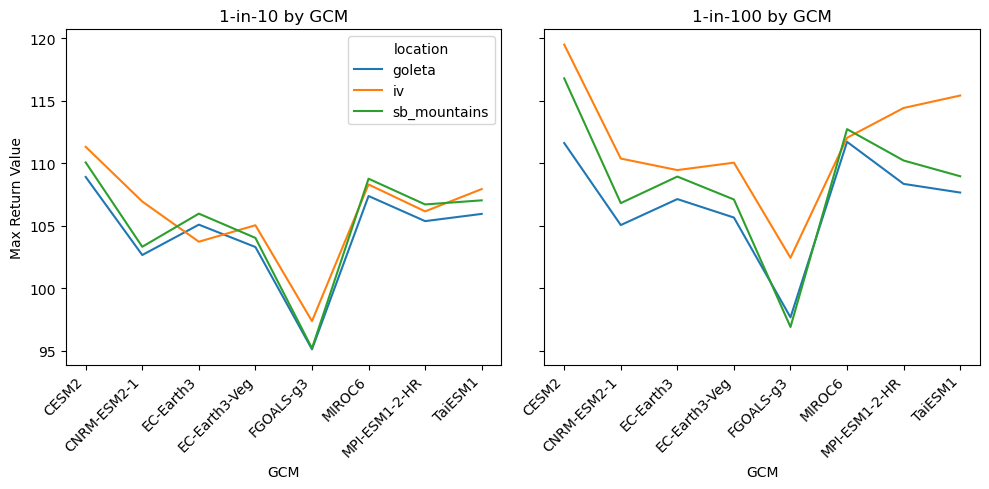

In [16]:
# Plotting the 1-in-X values by simulation for Santa Barbara locations
plot_retvals(calc_data_sb)

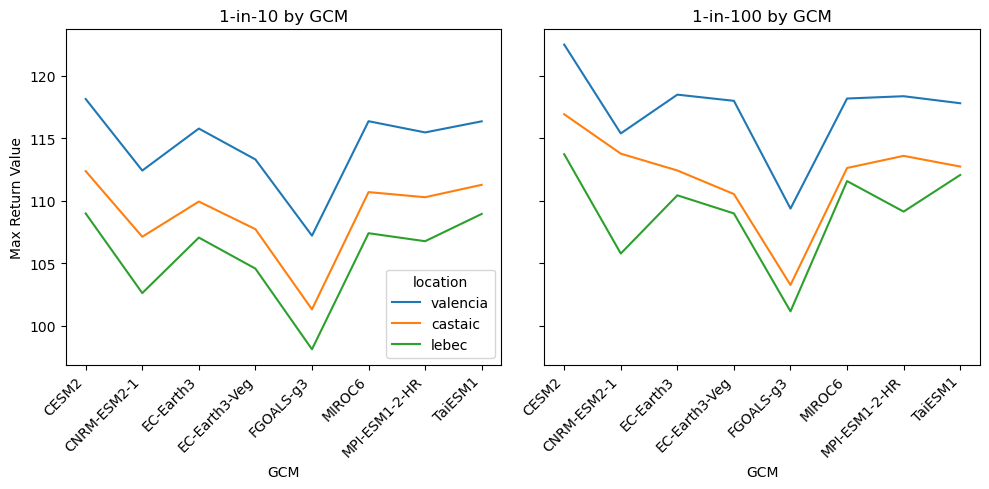

In [17]:
# Plotting the 1-in-X values by simulation for Santa Clarita locations
plot_retvals(calc_data_sc)

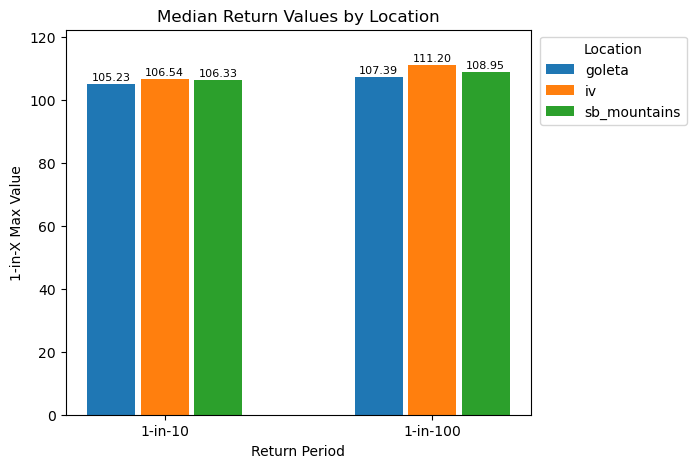

In [18]:
# Finding the median of the above plots along simulation dimension
plot_med_val_by_locs(calc_data_sb)

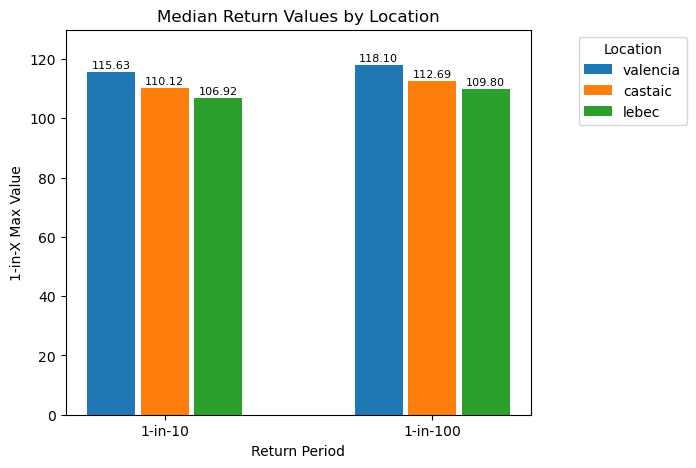

In [19]:
plot_med_val_by_locs(calc_data_sc)

In [20]:
### Finding the median `hour_of_year` that this 1-in-X event occurs for each simulation
med_hrs_sb = find_med_hrs(clean_raw_data_sb, all_one_in_x_sb)
med_hrs_sc = find_med_hrs(clean_raw_data_sc, all_one_in_x_sc)

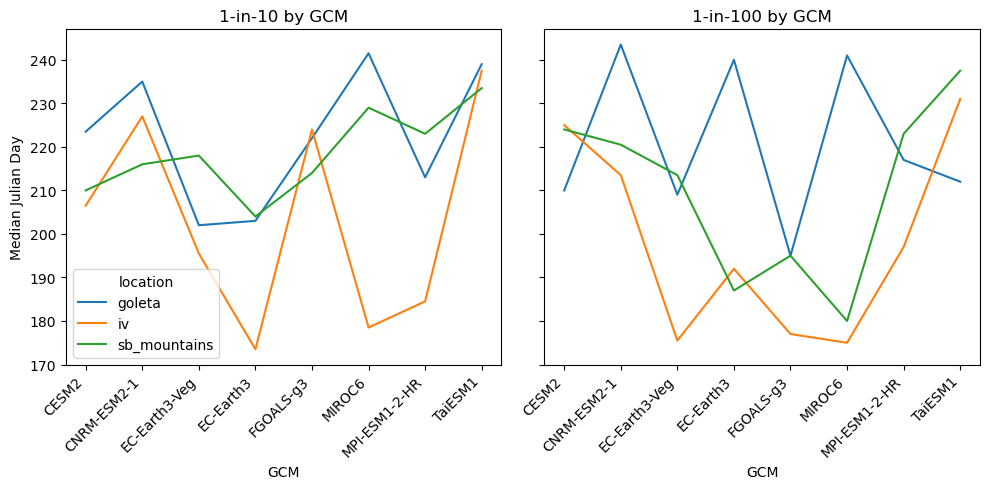

In [21]:
# Plotting the median `hour_of_year` by simulation for Santa Barbara locations
plot_retvals(med_hrs_sb, time_axis=True)

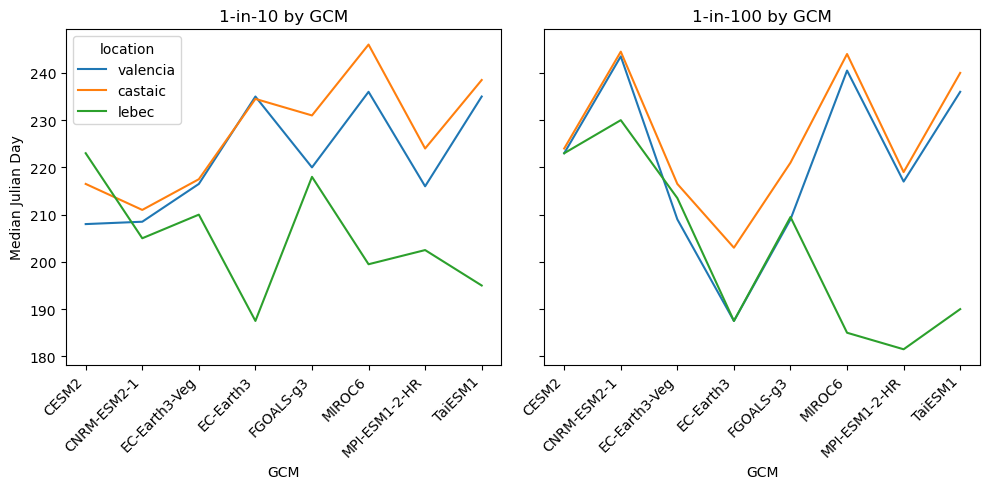

In [22]:
# Plotting the median `hour_of_year` by simulation for Santa Clairta locations
plot_retvals(med_hrs_sc, time_axis=True)

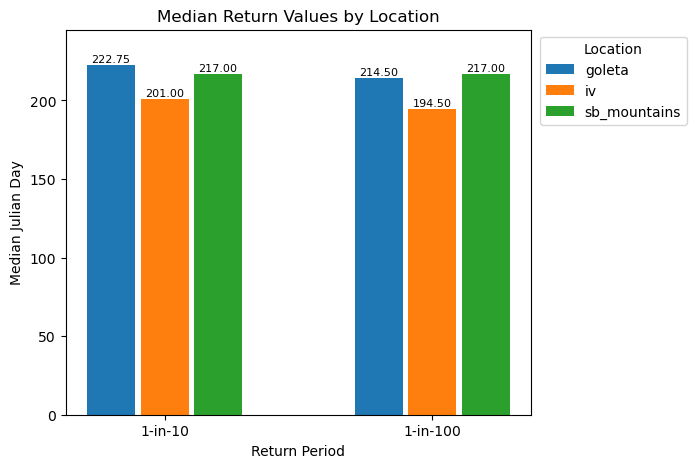

In [23]:
# Aggregating along simulation dimension
plot_med_val_by_locs(med_hrs_sb, time_axis=True)

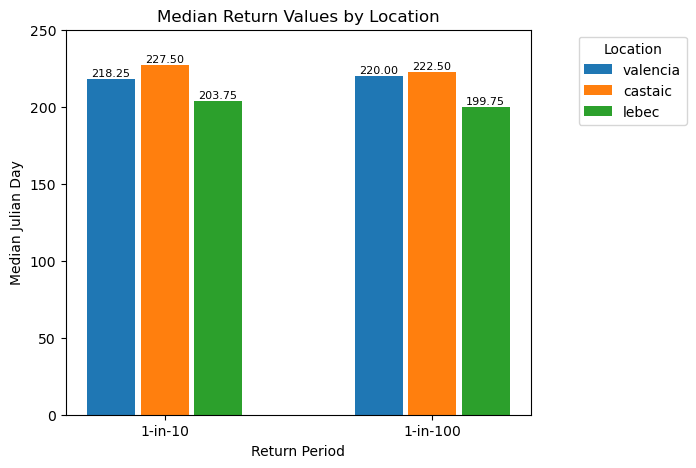

In [24]:
# Aggregating along simulation dimension
plot_med_val_by_locs(med_hrs_sc, time_axis=True)

### Inserting 1-in-X events into 8760s

In [25]:
# Calculating the modified 8760s with the 1-in-X events inserted in
median8760_sb = clean_raw_data_sb.groupby('hour_of_year').median().median(dim='simulation').squeeze()

modified8760_sb = insert_at_hrs(
    median8760_sb,    # (location, hour_of_year)
    med_hrs_sb.median(dim='simulation'),    # (location, one_in_x)
    calc_data_sb.median(dim='simulation'),  # (location, one_in_x)
    window=12
)

In [26]:
# Doing the same for Santa Clarita locations
median8760_sc = clean_raw_data_sc.groupby('hour_of_year').median().median(dim='simulation').squeeze()

modified8760_sc = insert_at_hrs(
    median8760_sc,    # (location, hour_of_year)
    med_hrs_sc.median(dim='simulation'),    # (location, one_in_x)
    calc_data_sc.median(dim='simulation'),  # (location, one_in_x)
    window=12
)

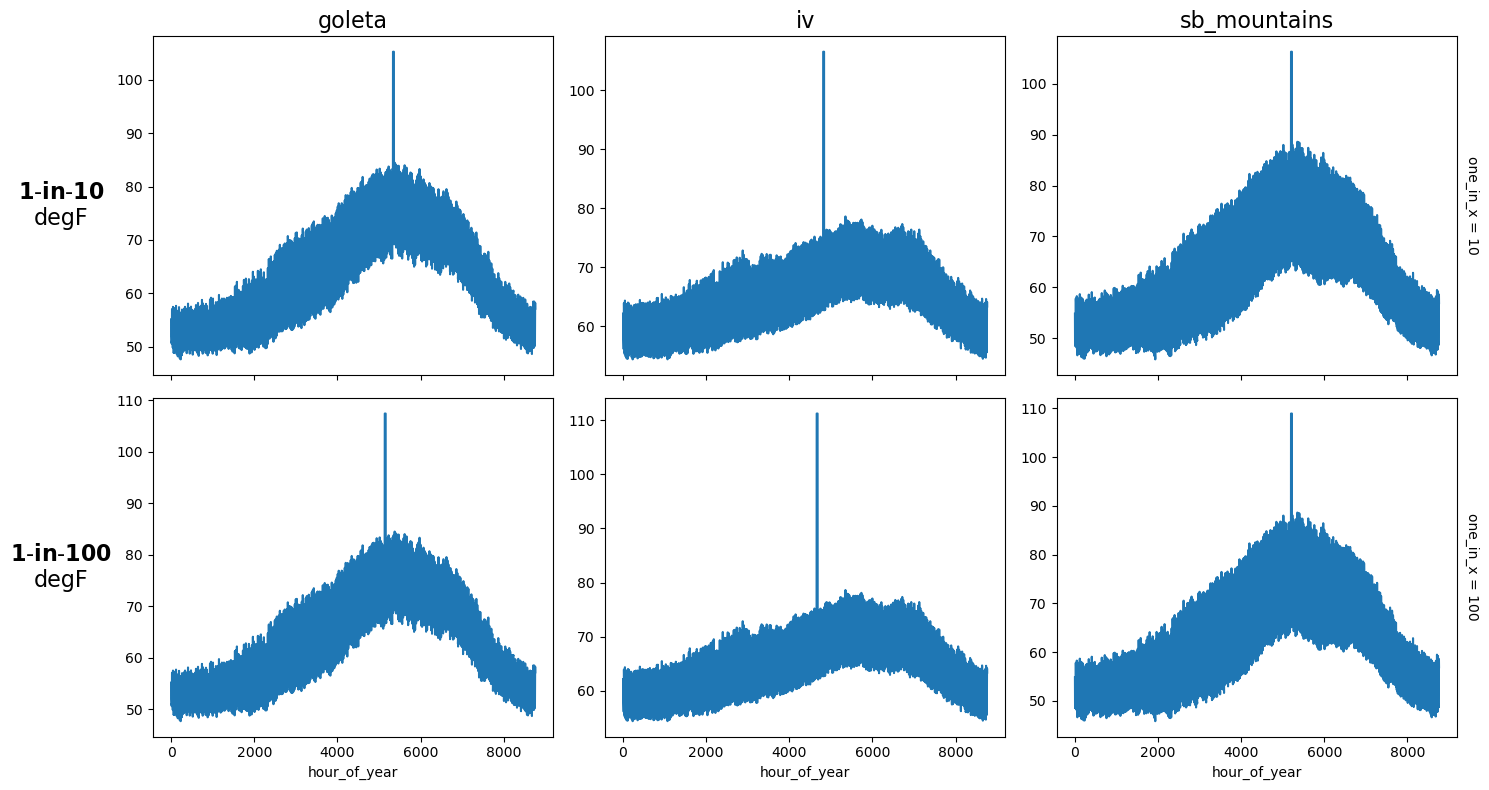

In [27]:
# Plot the modified 8760s
plot_modified8760s(modified8760_sb)

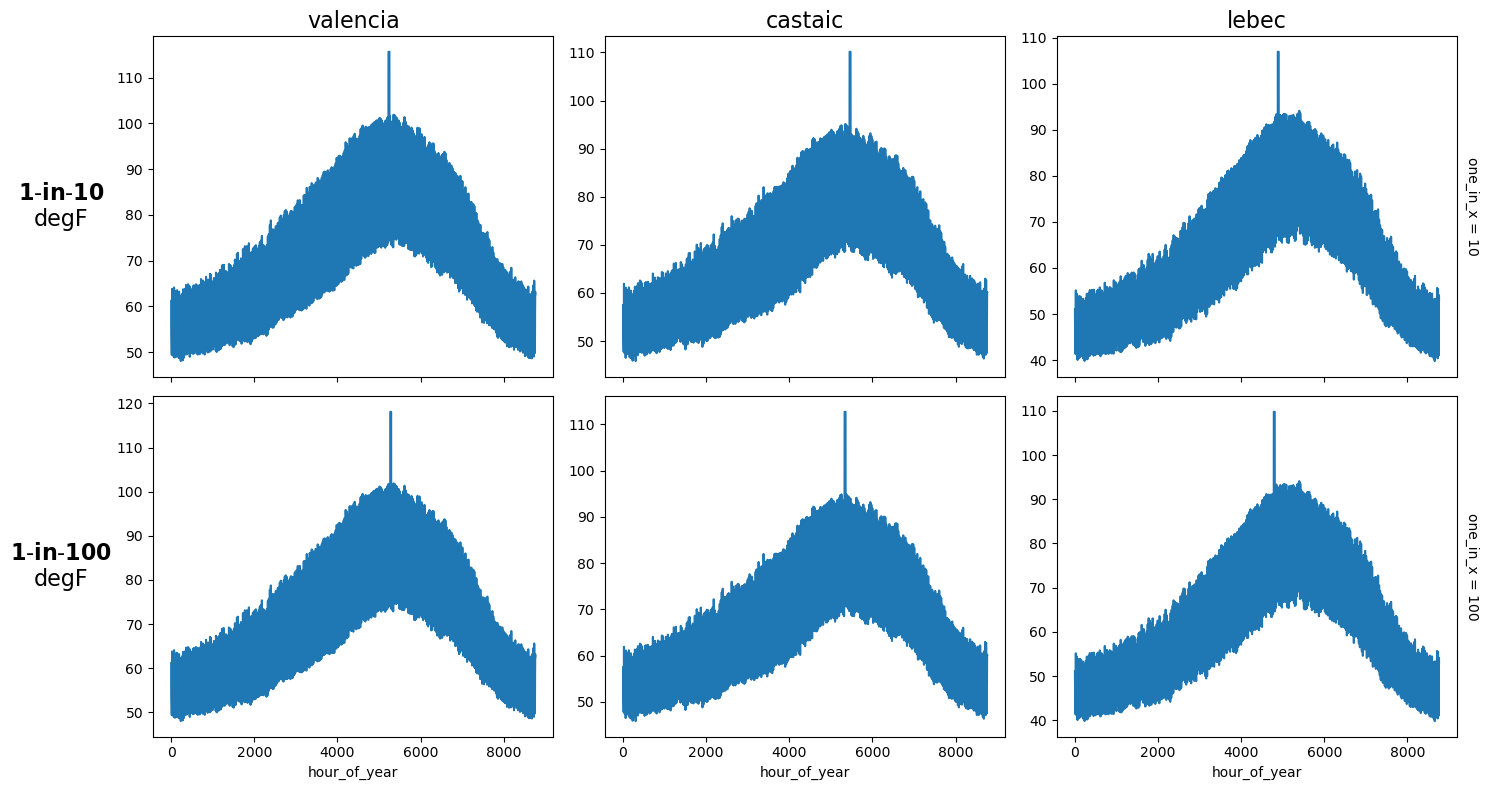

In [28]:
# Plot the modified 8760s
plot_modified8760s(modified8760_sc)